### TAREA 3 — Mejora de Imágenes (Pilotaje)

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
import psutil
print("CPUs disponibles:", psutil.cpu_count())
print("Uso actual de CPU:", psutil.cpu_percent(interval=1), "%")
print("RAM total (GB):", round(psutil.virtual_memory().total / (1024**3), 2))


CPUs disponibles: 16
Uso actual de CPU: 3.8 %
RAM total (GB): 31.26


In [3]:
!nvidia-smi

Sun Nov 16 12:58:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.57                 Driver Version: 581.57         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   39C    P0              6W /   80W |    1141MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
# Carpeta con las 1111 imágenes limpias
RUTA_ORIGINAL = r"C:\Users\GARI\Documents\DATASETS\DATASET_ORINAL_DESCARTADAS\dataset_eda_con labels\images"
EXT = (".jpg", ".jpeg", ".png")

In [6]:
RUTA_ORIGINAL

'C:\\Users\\GARI\\Documents\\DATASETS\\DATASET_ORINAL_DESCARTADAS\\dataset_eda_con labels\\images'

### Cálculo de brillo, contraste y saturación del dataset completo

In [1]:
# La función calcular_estadisticas abre cada imagen y mide brillo, contraste y saturación.
# Se utiliza cv2 para obtener métricas consistentes basadas en escala 0–255.

In [7]:
registros = []

for nombre in os.listdir(RUTA_ORIGINAL):
    if not nombre.lower().endswith(EXT):
        continue

    ruta = os.path.join(RUTA_ORIGINAL, nombre)

    # brillo/contraste
    img_gray = Image.open(ruta).convert("L")
    arr_gray = np.array(img_gray, dtype=np.float32)

    brillo = arr_gray.mean()
    contraste = arr_gray.std()

    # saturación
    img = cv2.imread(ruta)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    saturacion = hsv[:,:,1].mean()

    registros.append({
        "archivo": nombre,
        "brillo": brillo,
        "contraste": contraste,
        "saturacion": saturacion
    })

df_vis = pd.DataFrame(registros)
df_vis.head()


,archivo,brillo,contraste,saturacion
0,DJI_IMG_0001.jpg,98.249725,53.740101,53.247630
1,DJI_IMG_0002.jpg,112.951294,62.648632,51.301407
2,DJI_IMG_0003.jpg,94.883415,41.596046,40.748541
3,DJI_IMG_0004.jpg,92.955795,46.950279,60.300259
4,DJI_IMG_0005.jpg,128.860001,61.681431,42.328091


In [8]:
df_vis.describe()


,brillo,contraste,saturacion
count,1111.000000,1111.000000,1111.000000
mean,115.341911,52.435413,45.389536
std,22.510450,4.889875,10.878020
min,70.116112,33.316910,26.553994
25%,98.465733,49.151854,38.147378
50%,112.968506,52.079014,42.471980
75%,125.959766,55.660652,50.155488
max,194.794876,67.316368,99.073649


### BRILLO

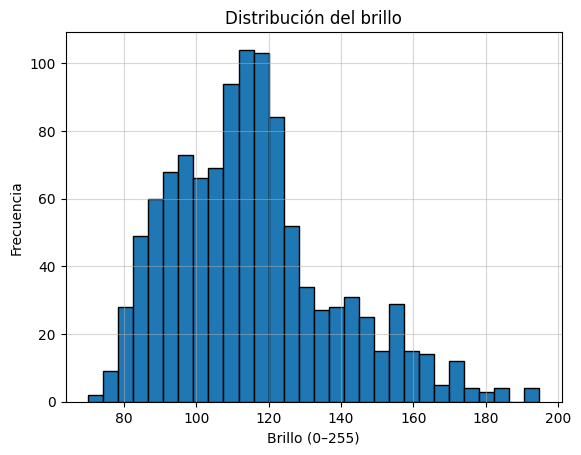

In [9]:
plt.hist(df_vis["brillo"], bins=30, edgecolor="black")
plt.title("Distribución del brillo")
plt.xlabel("Brillo (0–255)")
plt.ylabel("Frecuencia")
plt.grid(alpha=0.5)
plt.show()


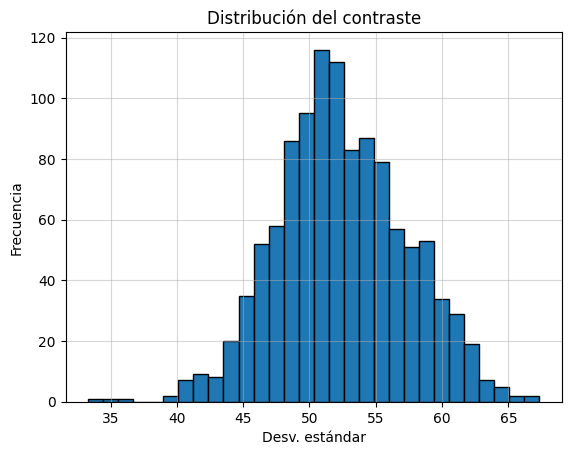

In [10]:
plt.hist(df_vis["contraste"], bins=30, edgecolor="black")
plt.title("Distribución del contraste")
plt.xlabel("Desv. estándar")
plt.ylabel("Frecuencia")
plt.grid(alpha=0.5)
plt.show()


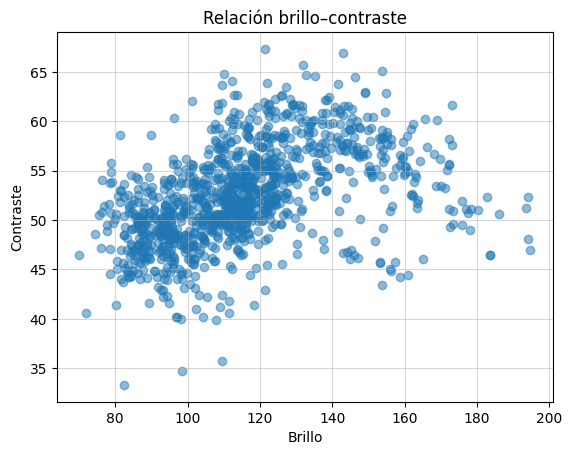

In [11]:
plt.scatter(df_vis["brillo"], df_vis["contraste"], alpha=0.5)
plt.xlabel("Brillo")
plt.ylabel("Contraste")
plt.title("Relación brillo–contraste")
plt.grid(alpha=0.5)
plt.show()


In [2]:
# Se convierte la imagen de BGR a HSV para calcular la saturación.
# El canal S (saturación) se promedia para obtener una medida global por imagen.

In [29]:
import os
import random

import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6,4)

# Ruta del dataset original validado (las 1111 imágenes)
RUTA_ORIGINAL = r"C:\Users\GARI\Documents\DATASETS\DATASET_IMAGENES_PUBLICAS_PRUEBAS"

# Extensiones válidas
EXT = (".jpg", ".jpeg", ".png")

# Listar imágenes
archivos = [f for f in os.listdir(RUTA_ORIGINAL) if f.lower().endswith(EXT)]
len(archivos)  # deberías ver 1111



12

In [30]:
def mejorar_optimo(ruta_entrada, ruta_salida):

    img = cv2.imread(ruta_entrada)
    if img is None:
        print("Error leyendo:", ruta_entrada)
        return

    # CLAHE suave
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8,8))
    L_eq = clahe.apply(L)
    lab_eq = cv2.merge((L_eq, A, B))
    img_eq = cv2.cvtColor(lab_eq, cv2.COLOR_LAB2BGR)

    # Brillo y contraste afinados
    img_bc = cv2.convertScaleAbs(img_eq, alpha=1.18, beta=20)

    # Saturación leve
    hsv = cv2.cvtColor(img_bc, cv2.COLOR_BGR2HSV).astype(np.float32)
    hsv[:,:,1] *= 1.10
    hsv[:,:,1] = np.clip(hsv[:,:,1], 0, 255)
    img_sat = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)

    # Nitidez suave
    blur = cv2.GaussianBlur(img_sat, (0,0), 1.0)
    sharpened = cv2.addWeighted(img_sat, 1.30, blur, -0.30, 0)

    cv2.imwrite(ruta_salida, sharpened)


In [31]:
# Muestra aleatoria de 10 imágenes
muestra = random.sample(archivos, 10)
muestra


['DJI_0581.jpg',
 'DJI_0580.jpg',
 'DJI_0588.jpg',
 'DJI_0589.jpg',
 'DJI_0582.jpg',
 'DJI_0579.jpg',
 'DJI_0586.jpg',
 'DJI_0585.jpg',
 'DJI_0587.jpg',
 'DJI_0583.jpg']

In [3]:
# Se aplica CLAHE (Equalización Adaptativa) para mejorar detalle y contraste.
# clipLimit y tileGridSize controlan la agresividad de la mejora.


In [34]:
RUTA_PILOTO_CLAHE = r"C:\Users\GARI\Documents\DATASETS\piloto_clahe1"
os.makedirs(RUTA_PILOTO_CLAHE, exist_ok=True)

for nombre in muestra:
    ruta_in = os.path.join(RUTA_ORIGINAL, nombre)
    ruta_out = os.path.join(RUTA_PILOTO_CLAHE, nombre)
    mejorar_optimo(ruta_in, ruta_out)

print("Procesamiento piloto con CLAHE completado.")


Procesamiento piloto con CLAHE completado.


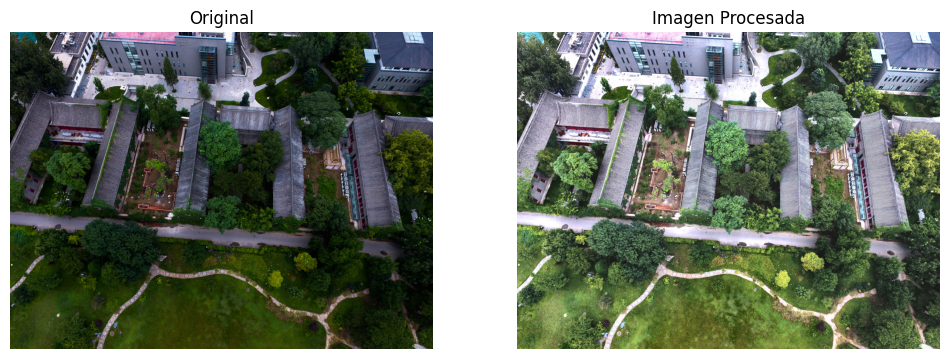

In [44]:
ejemplo = muestra[0]

ruta_in = os.path.join(RUTA_ORIGINAL, ejemplo)
ruta_out = os.path.join(RUTA_PILOTO_CLAHE, ejemplo)

ori = cv2.cvtColor(cv2.imread(ruta_in), cv2.COLOR_BGR2RGB)
mej = cv2.cvtColor(cv2.imread(ruta_out), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(ori)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mej)
plt.title("Imagen Procesada")
plt.axis("off")
plt.show()


In [4]:
# Se calcula nuevamente el brillo/contraste/saturación después de la mejora.
# Esto permite validar la efectividad real del proceso.

In [40]:
def calcular_estadisticas(ruta):
    img_gray = Image.open(ruta).convert("L")
    arr_gray = np.array(img_gray, dtype=np.float32)

    brillo = arr_gray.mean()
    contraste = arr_gray.std()

    img = cv2.imread(ruta)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    saturacion = hsv[:,:,1].mean()

    return brillo, contraste, saturacion

In [41]:
estadisticas = []

for nombre in muestra:
    ruta_o = os.path.join(RUTA_ORIGINAL, nombre)
    ruta_m = os.path.join(RUTA_PILOTO_CLAHE, nombre)
    
    bri_o, con_o, sat_o = calcular_estadisticas(ruta_o)
    bri_m, con_m, sat_m = calcular_estadisticas(ruta_m)
    
    estadisticas.append({
        "archivo": nombre,
        "brillo_original": bri_o,
        "brillo_mejorado": bri_m,
        "contraste_original": con_o,
        "contraste_mejorado": con_m,
        "saturacion_original": sat_o,
        "saturacion_mejorada": sat_m
    })

df_piloto = pd.DataFrame(estadisticas)
df_piloto.head()


,archivo,brillo_original,brillo_mejorado,contraste_original,contraste_mejorado,saturacion_original,saturacion_mejorada
0,DJI_0581.jpg,56.851948,116.075668,45.484909,65.166336,142.819395,80.994054
1,DJI_0580.jpg,56.643383,110.941437,51.108841,67.967339,105.723495,54.767435
2,DJI_0588.jpg,46.789619,103.734550,37.016891,60.231396,111.013706,60.597935
3,DJI_0589.jpg,48.257099,106.642967,40.340313,62.780483,104.543125,53.870737
4,DJI_0582.jpg,52.796089,113.360298,38.613472,59.843533,150.873403,88.144907


In [42]:
resumen = pd.DataFrame([
    {
        "Métrica": "Brillo",
        "Original": df_piloto["brillo_original"].mean(),
        "Mejorado": df_piloto["brillo_mejorado"].mean()
    },
    {
        "Métrica": "Contraste",
        "Original": df_piloto["contraste_original"].mean(),
        "Mejorado": df_piloto["contraste_mejorado"].mean()
    },
    {
        "Métrica": "Saturación",
        "Original": df_piloto["saturacion_original"].mean(),
        "Mejorado": df_piloto["saturacion_mejorada"].mean()
    }
])

resumen


,Métrica,Original,Mejorado
0,Brillo,50.927948,107.766884
1,Contraste,42.519493,63.512512
2,Saturación,121.834116,65.727884
